In [1]:
version = 'v20250521'

## read in data

In [2]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

prop = 'soc'
tgt = 'soc_log1p'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./material/pnt_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

## generate prediction and uncertainty

In [3]:
# train the model
from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")
model.fit(train[covs], train[tgt])

RandomForestRegressor(max_depth=30, max_features=0.3, min_samples_split=5,
                      n_estimators=64, n_jobs=90)

In [4]:
# generate prediction
y_pred = model.predict(test[covs])
y_pred = np.expm1(y_pred)
test[f'pred'] = y_pred

# cast the model
ttprint(f'start casting')
model = cast_node_rf(model, train[covs], train[tgt])

# generate uncertainty
ttprint(f'start predicting')
node_predictions = model.predict(test[covs])
nodes = pad_leaf_outputs_to_array(node_predictions, pad_value=np.nan)
nodes = nodes.T
ttprint(nodes.shape)
nodes = np.expm1(nodes)
test['pred_std'] = np.nanstd(nodes, axis=0)
ttprint(f'finish predicting')

[21:06:01] start casting
[21:06:14] start predicting
[21:06:41] (11380, 5400)
[21:06:41] finish predicting


In [5]:
test.loc[test['lc_survey']=='bareland', 'lc_survey'] = 'Bareland'
test.loc[test['lc_survey']=='wetland', 'lc_survey'] = 'Wetland'
test.loc[test['lc_survey']=='cropland', 'lc_survey'] = 'Cropland'
test.loc[test['lc_survey']=='woodland', 'lc_survey'] = 'Woodland'
test.loc[test['lc_survey']=='shrubland', 'lc_survey'] = 'Shrubland'
test.loc[test['lc_survey']=='grassland', 'lc_survey'] = 'Grassland'
test.loc[test['lc_survey']=='artificial land', 'lc_survey'] = 'Aritificial-land'

## organize soc series

In [6]:
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi',
            'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndvi_slope',
            'ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndwi_slope'}

test = test.rename(columns = name_map)
            
for col in ['ndvi','ndwi']:
    test[col] = (test[col]-125)/125

scol = ['id', 'ref', 'nuts0'] # static cols
mcol = ['lat', 'lon', 'soc', 'pred', 'ndvi','ndwi'] # average of the time series
tcol = ['time', 'soc', 'pred', 'lc_survey','ndvi','ndwi'] # time series cols


In [7]:
from skmap.misc import TimeTracker, ttprint

ttprint('start organizing')
ts = pd.DataFrame(columns=scol + [i+'_mean' for i in mcol] + [i+'_series' for i in tcol])
for iid in test['id'].unique():
    temp = test.loc[test['id'] == iid].sort_values(by=['time'])  
    
    # Extract static values (first row of static columns)
    static_vals = temp.iloc[0][scol].tolist()
    
    # Compute mean values for columns requiring averaging
    mean_vals = temp[mcol].mean().tolist()
    
    # Extract time series values as lists
    ts_vals = [temp[itcol].tolist() for itcol in tcol]
    
    # Concatenate all extracted values
    ts.loc[len(ts)] = static_vals + mean_vals + ts_vals
    
ttprint('finish organizing')
print(ts.shape)

[21:06:45] start organizing
[21:06:51] finish organizing
(1800, 15)


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
from sklearn.linear_model import HuberRegressor, TheilSenRegressor

lc_change = [] # whether land cover change happened
huber = HuberRegressor(alpha=0.0, epsilon=1)
tsr = TheilSenRegressor(random_state=42)
pts_o = [] # fitted linear line
pts_p = []
score_o = [] # R2 of predicted linear time series
score_p = []
slope_p = [] # linear slope
slope_o = []
intercept_p = [] # linear intercept
intercept_o = []

for index, row in ts.iterrows():
    o = row['soc_series']
    p = row['pred_series']
    t = row['time_series']
    
    # # soc time series
    # if (soc[2] > soc[1]) and (soc[1] > soc[0]):
    #     trend_class.append('increasing')
    # elif (soc[2] < soc[1]) and (soc[1] < soc[0]):
    #     trend_class.append('decreasing')
    # else:
    #     trend_class.append('varing')
        
    # land cover
    if len(set(row['lc_survey_series']))==1:
        lc_change.append(0)
    else:
        lc_change.append(1)
        
    # fit linear slope
    X = np.array(t)-2009
    # for observation
    tsr.fit(X.reshape(-1, 1), np.array(o))
    slope_o.append(tsr.coef_[0])
    intercept_o.append(tsr.intercept_)
    score_o.append(tsr.score(X.reshape(-1, 1), np.array(o)))
    pts_o.append(tsr.predict(X.reshape(-1, 1)))
    # for prediction
    tsr.fit(X.reshape(-1, 1), np.array(p))
    slope_p.append(tsr.coef_[0])
    intercept_p.append(tsr.intercept_)
    score_p.append(tsr.score(X.reshape(-1, 1), np.array(p)))
    pts_p.append(tsr.predict(X.reshape(-1, 1)))
    

ts['lc_change'] = lc_change
ts['slope_obsv'] = slope_o
ts['intercept_obsv'] = intercept_o
ts['score_obsv'] = score_o
ts['linear.ts_obsv'] = pts_o
ts['slope_pred'] = slope_p
ts['intercept_pred'] = intercept_p
ts['score_pred'] = score_p
ts['linear.ts_pred'] = pts_p


print(ts.shape)

(1800, 24)


## evaluate prediction accuracy for SOC change

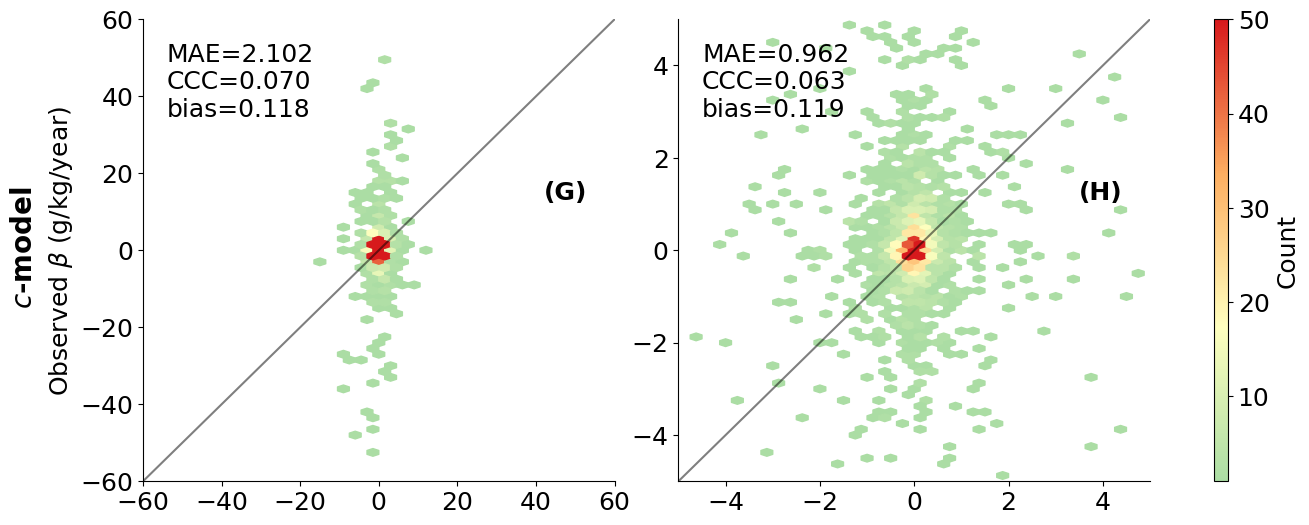

In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

vmax = 50
titles = ['Full range', 'Without outliers']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [-60, 60]
ax1 = fig.add_subplot(gs[0])
y_t = ts['slope_obsv']
y_p = ts['slope_pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb1 = ax1.hexbin(y_p, y_t, gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax)
ax1.set_xlabel(r'')#Predicted $\beta$ (g/kg/year)
ax1.set_ylabel(r'Observed $\beta$ (g/kg/year)')
ax1.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(G)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot 2
show_range = [-5, 5]
ax2 = fig.add_subplot(gs[1])
y_t = ts.loc[ts['slope_obsv'].abs() < 5, 'slope_obsv']
y_p = ts.loc[ts['slope_obsv'].abs() < 5, 'slope_pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb2 = ax2.hexbin(y_p, y_t, gridsize=(40, 40), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax)
ax2.set_xlabel(r'') #Predicted $\beta$ (g/kg/year)
ax2.set_ylabel(' ')
ax2.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(H)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(show_range, show_range, "-k", alpha=0.5)
ax2.set_xlim(show_range)
ax2.set_ylim(show_range)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')
fig.text(0.04, 0.5, r'$\it{c}$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.savefig(f'./figure/plot_mdl.pnt_evaluation.slope_pred.svg', bbox_inches='tight')
plt.show()

## change direction estimation

In [13]:
ts['direction_pred'] = ''
ts.loc[ts['slope_pred']>=0, 'direction_pred'] = 'increase'
ts.loc[ts['slope_pred']<0, 'direction_pred'] = 'decrease'

ts['direction_obsv'] = ''
ts.loc[ts['slope_obsv']>=0, 'direction_obsv'] = 'increase'
ts.loc[ts['slope_obsv']<0, 'direction_obsv'] = 'decrease'

In [14]:
from sklearn.metrics import f1_score, accuracy_score

y_true = ts['direction_obsv']
y_pred = ts['direction_pred']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='increase')
print(f'accuracy: {accuracy}; f1: {f1}')

accuracy: 0.5411111111111111; f1: 0.5625


### This is only a bit better than random guess

## SNR of series prediction

In [15]:
ts['lc_str'] = ts['lc_survey_series'].str[0] + '-' + ts['lc_survey_series'].str[1] + '-' + ts['lc_survey_series'].str[2]
l1 = ts['lc_str'].unique().tolist()
l2 = [ii.replace('land','') for ii in l1]
map_l = dict(zip(l1,l2))

ts['lc_str'] = ts['lc_str'].map(map_l)

#### Get the uncertainty of slope fitted from realizations of point predicitons of SOC

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression

std_slope_list = []
m_slope_list = []
std_score_list = []
m_score_list = []

tsr = TheilSenRegressor(random_state=42)

for index, row in ts.iterrows():
    o = row['soc_series']  # observed values, possibly unused here
    t = row['time_series']  # time points
    X = np.array(t) - 2009  # e.g., time normalization

    rt = []
    for step in t:
        ay = test.loc[(test['id'] == row['id']) & (test['time'] == step)].index
        rt.append(nodes[:, ay].squeeze())  # squeeze to (n_realizations,)

    # rt is now a list of arrays: each array is shape (n_realizations,) for that time step
    rt = np.array(rt).T  # shape becomes (n_realizations, n_time_steps), e.g., (120, 3)
    valid_indices = [np.where(~np.isnan(rt[:, j]))[0] for j in range(rt.shape[1])] # nan mask, to mask out the padded nan values from nodes

    slope_r = []
    score_r = []

    for i in range(50):  # 50 Monte Carlo samples
        ss = []
        # Sample one realization (index) per time step
        # Choose a random index from 0 to 119 (assuming 120 realizations)
        for j in range(rt.shape[1]):
            rand_idx = np.random.choice(valid_indices[j])
            ss.append(rt[rand_idx, j])

        ss = np.array(ss)

#         sample_indices = np.random.randint(0, rt.shape[0], size=rt.shape[1])
#         ss = np.array([rt[sample_indices[j], j] for j in range(rt.shape[1])])  # shape (n_time_steps,)

        tsr.fit(X.reshape(-1, 1), ss)
        slope_r.append(tsr.coef_[0])
        score_r.append(tsr.score(X.reshape(-1, 1), ss))

    # Store statistics
    std_slope_list.append(np.std(slope_r))
    m_slope_list.append(np.mean(slope_r))
    std_score_list.append(np.std(score_r))
    m_score_list.append(np.mean(score_r))

    
ts['slope_std'] = std_slope_list
ts['realizations_slope_m'] = m_slope_list
ts['score_std'] = std_score_list
ts['realizations_score_m'] = m_score_list

In [22]:
ts['signal'] = ts['slope_obsv'].abs()
ts['noise'] = ts['slope_std']
ts['snr'] = ts['slope_obsv'].abs()/ts['slope_std']

In [23]:
ts.to_parquet(f'./metric/srs_predicted.pnt_{version}.pq')


## analyze by land covers

In [21]:
coe = ts[['soc_mean','ndvi_mean','ndwi_mean','signal','noise','snr']].corr()
coe

,soc_mean,ndvi_mean,ndwi_mean,signal,noise,snr
soc_mean,1.000000,0.380749,0.353019,0.623155,0.590721,0.236582
ndvi_mean,0.380749,1.000000,0.918527,0.281925,0.626972,-0.042929
ndwi_mean,0.353019,0.918527,1.000000,0.256482,0.602370,-0.055812
signal,0.623155,0.281925,0.256482,1.000000,0.483632,0.528572
noise,0.590721,0.626972,0.602370,0.483632,1.000000,-0.047997
snr,0.236582,-0.042929,-0.055812,0.528572,-0.047997,1.000000


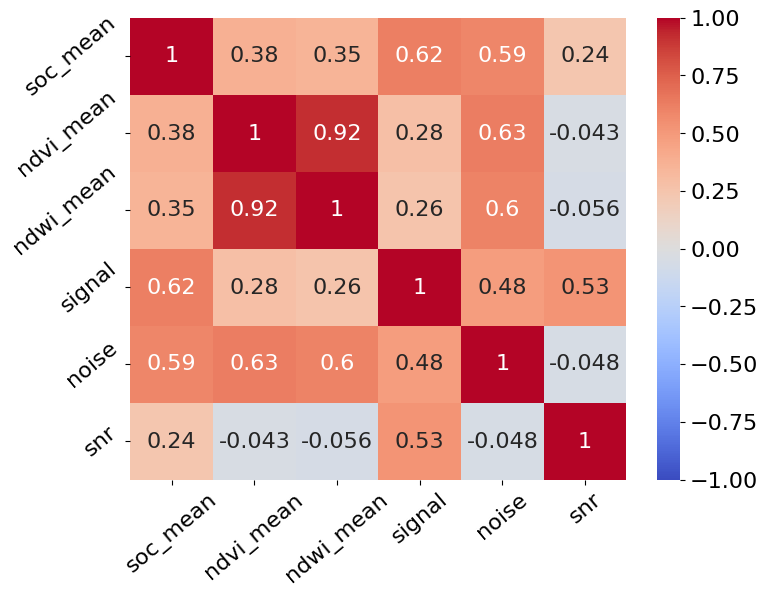

In [22]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=40)
plt.savefig(f'./figure/plot_corr_series.metrics.pdf', bbox_inches='tight')
plt.show()